In [3]:
import requests
from bs4 import BeautifulSoup
import json
import pandas as pd
import requests
import langdetect as ld
from time import sleep
from random import randint
from sklearn.feature_extraction.text import CountVectorizer

In [388]:
def get_comments(url,pages_num):
    column_names = ["review","star"]
    course_comments = pd.DataFrame(columns = column_names)
    for slug in range(1,pages_num+1):
        newUrl = url.replace('1', str(slug))
        response = requests.get(newUrl)
        sleep(randint(1, 3))
        soup = BeautifulSoup(response.text, 'lxml')
        for item in soup.find_all('script'):
            df = pd.DataFrame(columns = column_names)
            if 'ProductReviewsV1' in item.text:
                data=item.text.split('window.__APOLLO_STATE__ = ')[-1].split('};')[0] + "}"
                datajson=json.loads(data.strip())
                for key in datajson.keys():
                    if 'reviewText.cml' in key:
                        review_infos = datajson[key]
                        review = review_infos['value']
                        review = review.replace('</text>', '').replace('<text>', '').replace('<co-content>','').replace('</co-content>','').replace('<text />','')
                        starkey = key.replace(".reviewText.cml","").replace("$","")
                        star_infos = datajson[starkey] 
                        star = star_infos['rating']
                        df.loc[len(df.index)] = [review, star]      
            if(slug>1):           
                course_comments = pd.concat([course_comments, df.iloc[25::]], ignore_index = True)     
            else:
                course_comments = pd.concat([course_comments, df], ignore_index = True)
    return course_comments

In [255]:
course1 = get_comments('https://www.coursera.org/learn/what-is-datascience/reviews?page=1',400)
course2 = get_comments('https://www.coursera.org/learn/python-data-analysis/reviews?page=1',231)
course3 = get_comments('https://www.coursera.org/learn/statistical-inference/reviews?page=1',35)
course4 = get_comments('https://www.coursera.org/learn/python-text-mining/reviews?page=1',29)
course5 = get_comments('https://www.coursera.org/learn/ds/reviews?page=1',18)
course6 = get_comments('https://www.coursera.org/learn/data-wrangling-analysis-abtesting/reviews?page=1',11)
course7 = get_comments('https://www.coursera.org/learn/introduction-to-computer-programming/reviews?page=1',10)
course8 = get_comments('https://www.coursera.org/learn/finance-fundamentals/reviews?page=1', 8)
course9 = get_comments('https://www.coursera.org/learn/r-programming/reviews?page=1',185)
course10 = get_comments('https://www.coursera.org/learn/bioinformatics/reviews?page=1',17)

In [296]:
all_comments = pd.concat([course1,course2,course3,course4,course5,course6,course7,course8,course9,course10], ignore_index = True)
all_comments

,review,star
0,"Very basic course, to be honest. The grading ...",2
1,Too much introduction. There is no need to spe...,1
2,Videos often have disjointed or unrelated elem...,2
3,Too basic. If you live under a rock and have n...,1
4,"This was a good introductory course, especiall...",5
...,...,...
23480,This course is not at all beginner level.,1
23481,Iâs very difficult for biggeners,1
23482,definitely not for beginners,1
23483,its not for beginners,1


In [273]:
def is_en(txt):
    try:
        return ld.detect(txt)=='en'
    except:
        return False

In [297]:
all_comments = all_comments[all_comments['review'].apply(is_en)]
all_comments['star'] = all_comments['star'].astype('int')
all_comments

C:\Users\anarb\AppData\Local\Temp\ipykernel_19320\2153033491.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_comments['star'] = all_comments['star'].astype('int')


,review,star
0,"Very basic course, to be honest. The grading ...",2
1,Too much introduction. There is no need to spe...,1
2,Videos often have disjointed or unrelated elem...,2
3,Too basic. If you live under a rock and have n...,1
4,"This was a good introductory course, especiall...",5
...,...,...
23476,Not for beginners and the output window is bad...,1
23477,I am a beginner and this is very difficult to ...,1
23478,Too tough for someone who does not know progra...,1
23479,This course is absolutely terrible for begginers,1


In [298]:
all_comments.groupby('star').nunique()

,review
star,
1,905
2,836
3,1398
4,4298
5,12417


In [300]:
all_comments['label'] =  all_comments.apply(lambda row: 1 if row['star'] > 3 else 0 ,axis=1)

C:\Users\anarb\AppData\Local\Temp\ipykernel_19320\861213508.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_comments['label'] =  all_comments.apply(lambda row: 1 if row['star'] > 3 else 0 ,axis=1)


In [301]:
all_comments

,review,star,label
0,"Very basic course, to be honest. The grading ...",2,0
1,Too much introduction. There is no need to spe...,1,0
2,Videos often have disjointed or unrelated elem...,2,0
3,Too basic. If you live under a rock and have n...,1,0
4,"This was a good introductory course, especiall...",5,1
...,...,...,...
23476,Not for beginners and the output window is bad...,1,0
23477,I am a beginner and this is very difficult to ...,1,0
23478,Too tough for someone who does not know progra...,1,0
23479,This course is absolutely terrible for begginers,1,0


In [18]:
all_comments.to_csv('comments.csv', index= False)

In [4]:
df = pd.read_csv('comments.csv')

In [5]:
df = df.drop('star', axis=1)
df

,review,label
0,"Very basic course, to be honest. The grading ...",0
1,Too much introduction. There is no need to spe...,0
2,Videos often have disjointed or unrelated elem...,0
3,Too basic. If you live under a rock and have n...,0
4,"This was a good introductory course, especiall...",1
...,...,...
20419,Not for beginners and the output window is bad...,0
20420,I am a beginner and this is very difficult to ...,0
20421,Too tough for someone who does not know progra...,0
20422,This course is absolutely terrible for begginers,0


In [6]:
from collections import Counter

vocab = Counter()
for text in df.review:
    for word in text.split(' '):
        vocab[word] += 1

vocab.most_common(20)

[('the', 24263),
 ('to', 18404),
 ('and', 15269),
 ('a', 11675),
 ('of', 10614),
 ('course', 10330),
 ('I', 9804),
 ('is', 9456),
 ('in', 7933),
 ('', 7767),
 ('for', 7059),
 ('this', 5372),
 ('data', 5276),
 ('very', 4418),
 ('you', 4258),
 ('are', 4149),
 ('The', 4147),
 ('it', 4139),
 ('was', 4139),
 ('with', 3846)]

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
import re
import string
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

stop_words = stopwords.words()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anarb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anarb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


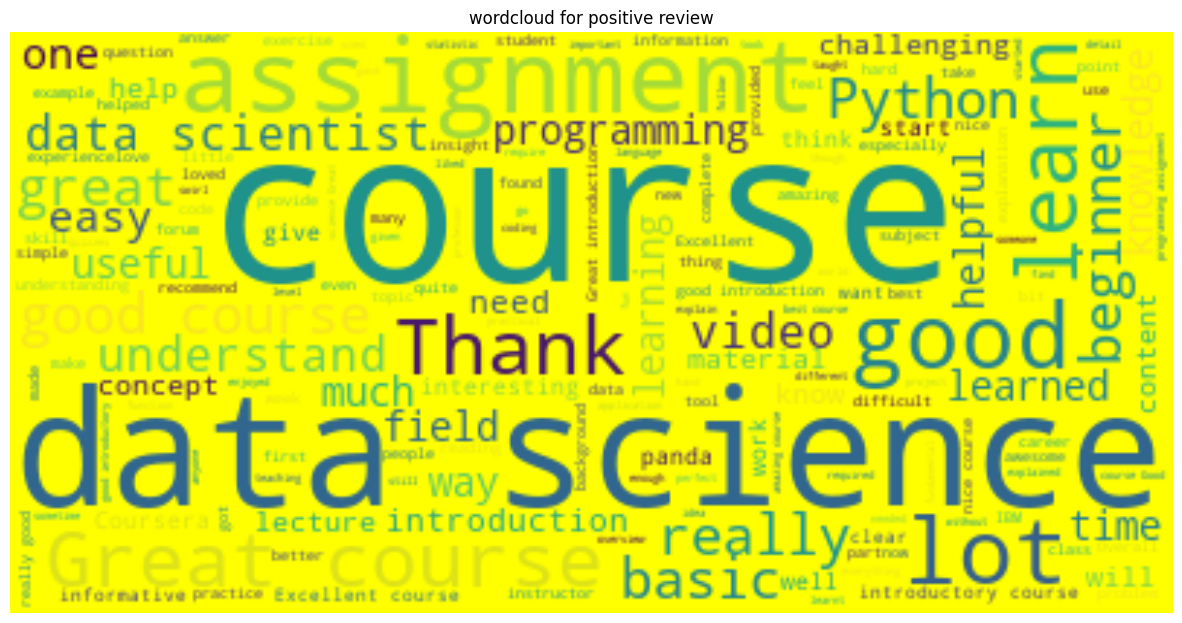

In [8]:
text = " ".join(i for i in df[df['label']==1]['review'])
wordcloud = WordCloud( background_color="yellow").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('wordcloud for positive review')
plt.show()

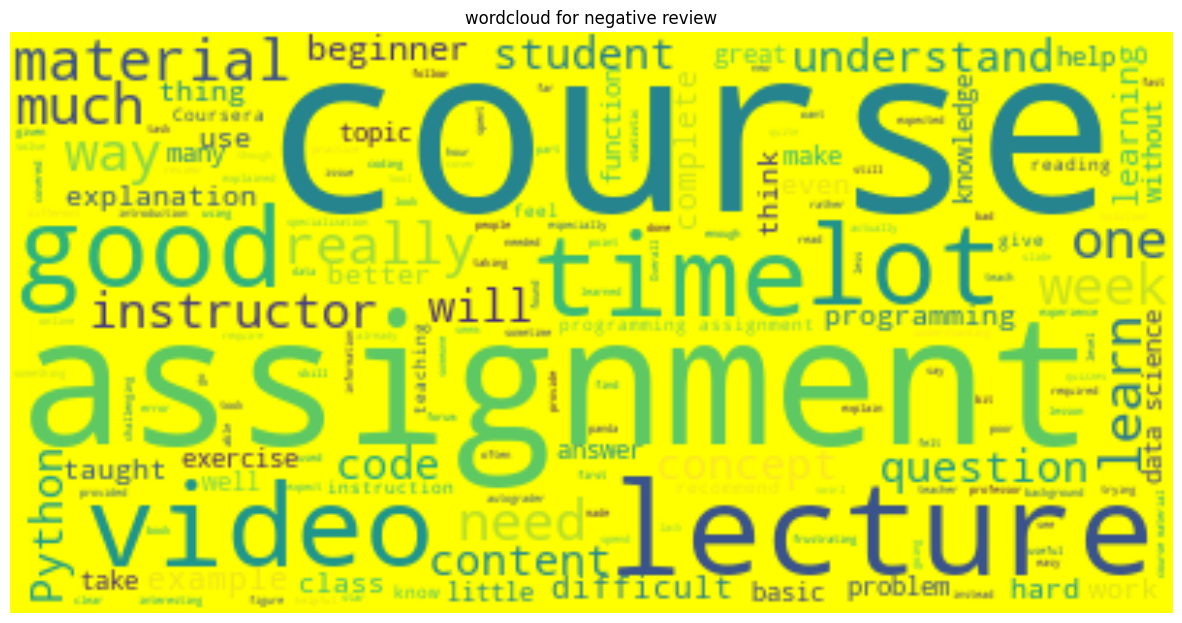

In [9]:
text = " ".join(i for i in df[df['label']==0]['review'])
wordcloud = WordCloud( background_color="yellow").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('wordcloud for negative review')
plt.show()

In [10]:
import itertools
from nltk.stem import WordNetLemmatizer
from autocorrect import Speller
def text_clean(text):        
    text = text.lower() 
    text = re.sub('https?://\S+|www\.\S+', '', text) 
    text = re.sub(r"\b\d+\b", "", text) 
    text = re.sub('<.*?>+', '', text) 
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) 
    text = re.sub('\n', '', text)
    text = re.sub('[’“”…]', '', text)
   
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F" 
                           u"\U0001F300-\U0001F5FF"  
                           u"\U0001F680-\U0001F6FF" 
                           u"\U0001F1E0-\U0001F1FF"  
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)   
    text = re.sub(r"\'t", "not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
       
    return text

def delete_stopwords(text):
    stop_words = set(stopwords.words('english'))
    stop_words.remove('not')
    stop_words.remove('no')
    stop_words.remove('too')
    return ' '.join([word for word in text.split() if word not in (stop_words)])

def autocorrect(text):
    text = ''.join(''.join(s)[:2] for _, s in itertools.groupby(text))
    spell = Speller(lang='en')
    correct_text = spell(text)
    return correct_text
    
print(autocorrect('I am beginer'))  

I am beginner


In [11]:
from nltk.corpus import wordnet
lemmatizer = WordNetLemmatizer()

def nltk_pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None
    
def lemmatize_sentence(sentence):

    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    wordnet_tagged = map(lambda x: (x[0], nltk_pos_tagger(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:        
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

print(lemmatize_sentence("This course provides helpful insights into data science and relevant terminologies. I definitely suggest you complete it before going ahead with data science. "))


This course provide helpful insight into data science and relevant terminology . I definitely suggest you complete it before go ahead with data science .


In [12]:
df['cleaned_review'] = df['review'].apply(lambda text: text_clean(text))
df['cleaned_review'] = df['cleaned_review'].apply(lambda text: delete_stopwords(text))
#df['cleaned_review'] = df['cleaned_review'].apply(lambda text: autocorrect(text))
df['cleaned_review'] = df['cleaned_review'].apply(lambda text: lemmatize_sentence(text))

In [14]:
df

,review,label,cleaned_review
0,"Very basic course, to be honest. The grading ...",0,basic course honest grading seem dependent mem...
1,Too much introduction. There is no need to spe...,0,too much introduction no need spend much time ...
2,Videos often have disjointed or unrelated elem...,0,video often disjoint unrelated element final w...
3,Too basic. If you live under a rock and have n...,0,too basic live rock never hear data science da...
4,"This was a good introductory course, especiall...",1,good introductory course especially someone ba...
...,...,...,...
20419,Not for beginners and the output window is bad...,0,not beginner output window badly program
20420,I am a beginner and this is very difficult to ...,0,beginner difficult understand
20421,Too tough for someone who does not know progra...,0,too tough someone not know program
20422,This course is absolutely terrible for begginers,0,course absolutely terrible begginers


In [15]:
from collections import Counter
cnt = Counter()
for text in df["cleaned_review"].values:
    for word in text.split():
        cnt[word] += 1
cnt.most_common(10)
word_freq = pd.DataFrame(cnt.most_common(10))
word_freq.columns=['word', 'count']
word_freq

,word,count
0,course,15961
1,data,8424
2,science,6091
3,good,5393
4,assignment,4636
5,learn,3991
6,great,3813
7,not,3787
8,really,2370
9,lot,2196


In [16]:
most_common_words = set([w for (w, wc) in cnt.most_common(3)])

def remove_freqwords(text):
    return " ".join([word for word in str(text).split() if word not in most_common_words])

df["cleaned_review"] = df["cleaned_review"].apply(lambda text: remove_freqwords(text))

In [17]:
print("Original review:", df.iloc[0]['review'])
print()
print("Cleaned review:", df.iloc[0]['cleaned_review'])

Original review: Very basic course, to be honest.  The grading seemed to be dependent on memorizing exact quotes from videos.  Looking forward to some of the more advanced courses in this series.

Cleaned review: basic honest grading seem dependent memorizing exact quote video look forward advanced series


In [18]:
df = df.drop('review',axis=1)
df = df.rename({'cleaned_review': 'text'}, axis=1) 
df

,label,text
0,0,basic honest grading seem dependent memorizing...
1,0,too much introduction no need spend much time ...
2,0,video often disjoint unrelated element final w...
3,0,too basic live rock never hear scientist term ...
4,1,good introductory especially someone basically...
...,...,...
20419,0,not beginner output window badly program
20420,0,beginner difficult understand
20421,0,too tough someone not know program
20422,0,absolutely terrible begginers


In [19]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
text_count = cv.fit_transform(df['text'])

In [20]:
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(text_count, df['label'],test_size=0.25,random_state=71,shuffle=True)

model_nb = MultinomialNB()
model_nb.fit(x_train, y_train)
score_nb = metrics.accuracy_score(model_nb.predict(x_test), y_test)


model_lr = LogisticRegression()
model_lr.fit(x_train, y_train)
score_lr = metrics.accuracy_score(model_lr.predict(x_test), y_test)


model_per = Perceptron()
model_per.fit(x_train, y_train)
score_per = metrics.accuracy_score(model_per.predict(x_test), y_test)

print('accuracy of Naive Bayes model= '+str('{:4.2f}'.format(score_nb*100))+'%')
print('accuracy of Logistic Regression model = '+str('{:4.2f}'.format(score_lr*100))+'%')
print('accuracy of Perceptron model = '+str('{:4.2f}'.format(score_per*100))+'%')

accuracy of Naive Bayes model= 90.97%
accuracy of Logistic Regression model = 91.66%
accuracy of Perceptron model = 87.86%


C:\Users\anarb\anaconda3\envs\ml\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [29]:
def predict(text):
    text = text_clean(text)
    text = delete_stopwords(text)
    text = lemmatize_sentence(text)
    text_list = [text]
    count_vector = cv.transform(text_list)
    pred = model_per.predict(count_vector)
    if pred[0] == 0:
        return "Negative"
    return "Positive" 

In [38]:
print(predict("don't"))
print(predict("do not"))
print(predict('For me it was interesting'))
print(predict('worst time spending'))
print(predict("absolutely useless couse"))
print(predict("This course is terrible for beginners!! None of the modules go in depth, it was difficult to understand because none of the commands are explained,"))

Negative
Negative
Positive
Negative
Negative
Negative
